# Pembuka
Notebook ini merapikan dataset audio FI-V2: memperbaiki path file, memuat meta + fitur, menjalankan EDA ringkas, menghitung ulang VAD, membersihkan data, dan membekukan split K-Fold. Jalankan sel berurutan; penjelasan di setiap sel memberi tujuan dan harapan output.

In [28]:
# A) Setup & Load
from pathlib import Path
import pandas as pd

DATASET_ROOT = Path("/kaggle/input/checkpointcvpr-1")  # ganti jika slug dataset beda
WORK         = Path("/kaggle/working")
WORK.mkdir(exist_ok=True, parents=True)

META_CLEAN = DATASET_ROOT / "fi_v2_meta.clean.csv"
assert META_CLEAN.exists(), f"Tidak ketemu: {META_CLEAN}"

df = pd.read_csv(META_CLEAN)
BIG5 = ["extraversion","agreeableness","conscientiousness","neuroticism","openness"]
print(df.shape)
df.head()


(5997, 10)


,raw_id,group_id,relpath,extraversion,agreeableness,conscientiousness,neuroticism,openness,wav_path,duration_sec
0,J4GQm9j0JZ0.003.mp4,J4GQm9j0JZ0.003,train-5/training80_60/J4GQm9j0JZ0.003.mp4,0.523364,0.626374,0.601942,0.552083,0.488889,/kaggle/working/wav/J4GQm9j0JZ0.003.wav,15.301938
1,zEyRyTnIw5I.005.mp4,zEyRyTnIw5I.005,train-6/training80_71/zEyRyTnIw5I.005.mp4,0.345794,0.472527,0.582524,0.375000,0.366667,/kaggle/working/wav/zEyRyTnIw5I.005.wav,15.301938
2,nskJh7v6v1U.004.mp4,nskJh7v6v1U.004,train-5/training80_52/nskJh7v6v1U.004.mp4,0.252336,0.406593,0.485437,0.291667,0.511111,/kaggle/working/wav/nskJh7v6v1U.004.wav,15.301938
3,6wHQsN5g2RM.000.mp4,6wHQsN5g2RM.000,train-3/training80_36/6wHQsN5g2RM.000.mp4,0.457944,0.505495,0.398058,0.489583,0.377778,/kaggle/working/wav/6wHQsN5g2RM.000.wav,15.301938
4,dQOeQYWIgm8.000.mp4,dQOeQYWIgm8.000,train-6/training80_70/dQOeQYWIgm8.000.mp4,0.607477,0.406593,0.621359,0.489583,0.622222,/kaggle/working/wav/dQOeQYWIgm8.000.wav,15.301938


#### Penjelasan (Sel 1)
- Memuat meta fi_v2_meta.clean.csv dari dataset input dan menyiapkan folder kerja.
- Tampilkan ukuran dataframe serta contoh baris untuk memastikan file siap diproses.

In [29]:
# Remap wav_path dari /kaggle/working -> /kaggle/input/<your-dataset>/wav
from pathlib import Path
import pandas as pd

DATASET_ROOT = Path("/kaggle/input/checkpointcvpr-1")   # ganti jika nama dataset beda
META_IN  = DATASET_ROOT / "fi_v2_meta.clean.csv"        # meta di input (dataset barumu)
META_OUT = Path("/kaggle/working/fi_v2_meta.clean.inputpaths.csv")  # simpan versi path-fix

df = pd.read_csv(META_IN)

def remap_wav_path(old_path: str, raw_id: str) -> str | None:
    """
    Prioritas:
    1) Ambil nama file dari old_path -> /kaggle/input/.../wav/<name>
    2) Kalau gagal, coba dari raw_id (ganti ekstensi ke .wav)
    """
    # kandidat 1: pakai nama file dari old_path
    name = None
    if isinstance(old_path, str) and len(old_path):
        name = Path(old_path).name  # contoh: J4GQm9j0JZ0.003.wav
    # kandidat 2: dari raw_id
    if not name and isinstance(raw_id, str) and len(raw_id):
        name = Path(raw_id).with_suffix(".wav").name

    if not name:
        return None

    newp = DATASET_ROOT / "wav" / name
    return str(newp) if newp.exists() else None

df["wav_path"] = df.apply(lambda r: remap_wav_path(r.get("wav_path"), r.get("raw_id")), axis=1)

ok = df["wav_path"].notna().sum()
miss = len(df) - ok
print(f"Remapped wav_path OK: {ok}/{len(df)} | missing: {miss}")

# Lihat contoh & yang masih missing
display(df[["raw_id","wav_path"]].head(8))
if miss:
    display(df[df["wav_path"].isna()][["raw_id"]].head(10))

# Simpan hasil remap (jangan overwrite input)
df.to_csv(META_OUT, index=False)
print("Saved:", META_OUT)


Remapped wav_path OK: 5997/5997 | missing: 0


,raw_id,wav_path
0,J4GQm9j0JZ0.003.mp4,/kaggle/input/checkpointcvpr-1/wav/J4GQm9j0JZ0...
1,zEyRyTnIw5I.005.mp4,/kaggle/input/checkpointcvpr-1/wav/zEyRyTnIw5I...
2,nskJh7v6v1U.004.mp4,/kaggle/input/checkpointcvpr-1/wav/nskJh7v6v1U...
3,6wHQsN5g2RM.000.mp4,/kaggle/input/checkpointcvpr-1/wav/6wHQsN5g2RM...
4,dQOeQYWIgm8.000.mp4,/kaggle/input/checkpointcvpr-1/wav/dQOeQYWIgm8...
5,eHcRre1YsNA.000.mp4,/kaggle/input/checkpointcvpr-1/wav/eHcRre1YsNA...
6,vZpneJlniAE.005.mp4,/kaggle/input/checkpointcvpr-1/wav/vZpneJlniAE...
7,oANKg9_grdA.004.mp4,/kaggle/input/checkpointcvpr-1/wav/oANKg9_grdA...


Saved: /kaggle/working/fi_v2_meta.clean.inputpaths.csv


#### Penjelasan (Sel 2)
- Menyusun ulang wav_path agar menunjuk ke folder input resmi, dengan fallback dari raw_id.
- Menyimpan versi path-fix ke fi_v2_meta.clean.inputpaths.csv supaya langkah berikut tidak gagal karena path.

In [30]:
df.head(10)

,raw_id,group_id,relpath,extraversion,agreeableness,conscientiousness,neuroticism,openness,wav_path,duration_sec
0,J4GQm9j0JZ0.003.mp4,J4GQm9j0JZ0.003,train-5/training80_60/J4GQm9j0JZ0.003.mp4,0.523364,0.626374,0.601942,0.552083,0.488889,/kaggle/input/checkpointcvpr-1/wav/J4GQm9j0JZ0...,15.301938
1,zEyRyTnIw5I.005.mp4,zEyRyTnIw5I.005,train-6/training80_71/zEyRyTnIw5I.005.mp4,0.345794,0.472527,0.582524,0.375000,0.366667,/kaggle/input/checkpointcvpr-1/wav/zEyRyTnIw5I...,15.301938
2,nskJh7v6v1U.004.mp4,nskJh7v6v1U.004,train-5/training80_52/nskJh7v6v1U.004.mp4,0.252336,0.406593,0.485437,0.291667,0.511111,/kaggle/input/checkpointcvpr-1/wav/nskJh7v6v1U...,15.301938
3,6wHQsN5g2RM.000.mp4,6wHQsN5g2RM.000,train-3/training80_36/6wHQsN5g2RM.000.mp4,0.457944,0.505495,0.398058,0.489583,0.377778,/kaggle/input/checkpointcvpr-1/wav/6wHQsN5g2RM...,15.301938
4,dQOeQYWIgm8.000.mp4,dQOeQYWIgm8.000,train-6/training80_70/dQOeQYWIgm8.000.mp4,0.607477,0.406593,0.621359,0.489583,0.622222,/kaggle/input/checkpointcvpr-1/wav/dQOeQYWIgm8...,15.301938
5,eHcRre1YsNA.000.mp4,eHcRre1YsNA.000,train-2/training80_14/eHcRre1YsNA.000.mp4,0.196262,0.351648,0.262136,0.302083,0.566667,/kaggle/input/checkpointcvpr-1/wav/eHcRre1YsNA...,15.301938
6,vZpneJlniAE.005.mp4,vZpneJlniAE.005,train-5/training80_55/vZpneJlniAE.005.mp4,0.420561,0.571429,0.466019,0.635417,0.633333,/kaggle/input/checkpointcvpr-1/wav/vZpneJlniAE...,15.301938
7,oANKg9_grdA.004.mp4,oANKg9_grdA.004,train-5/training80_60/oANKg9_grdA.004.mp4,0.429907,0.626374,0.582524,0.583333,0.588889,/kaggle/input/checkpointcvpr-1/wav/oANKg9_grdA...,15.301938
8,VuadgOz6T7s.000.mp4,VuadgOz6T7s.000,train-4/training80_38/VuadgOz6T7s.000.mp4,0.224299,0.153846,0.145631,0.135417,0.233333,/kaggle/input/checkpointcvpr-1/wav/VuadgOz6T7s...,15.301938
9,7nhJXn9PI0I.001.mp4,7nhJXn9PI0I.001,train-4/training80_48/7nhJXn9PI0I.001.mp4,0.177570,0.186813,0.417476,0.197917,0.355556,/kaggle/input/checkpointcvpr-1/wav/7nhJXn9PI0I...,15.301938


#### Penjelasan (Sel 3)
- Meninjau 10 baris pertama setelah remap memastikan kolom label dan wav_path terlihat benar.

# **EKSTRAKSI FITUR LIBROSA**

In [31]:
# === Load meta + pastikan wav_path valid tanpa merusak yang sudah benar ===
from pathlib import Path
import pandas as pd

# Lokasi dataset input yang berisi folder wav/
INPUT_ROOT = Path("/kaggle/input/checkpointcvpr-1")   # ganti jika slug beda
WORK       = Path("/kaggle/working")

# Meta bisa saja di working; pakai yang ada
candidates = [
    WORK / "fi_v2_meta.clean.inputpaths.csv",
    INPUT_ROOT / "fi_v2_meta.clean.csv",
]
META_SRC = next((p for p in candidates if p.exists()), None)
assert META_SRC is not None, "Meta CSV tidak ditemukan di working maupun input."
print("Using meta:", META_SRC)

df = pd.read_csv(META_SRC)

def ensure_input_wav_path(row):
    p = row.get("wav_path")
    # 1) kalau sudah /kaggle/input/... dan file ada -> pakai saja
    if isinstance(p, str) and p.startswith("/kaggle/input/") and Path(p).exists():
        return p
    # 2) bangun dari nama file (ambil dari wav_path lama atau raw_id)
    name = None
    if isinstance(p, str) and p:
        name = Path(p).name
    if not name and isinstance(row.get("raw_id"), str):
        name = Path(row["raw_id"]).with_suffix(".wav").name
    if not name:
        return None
    cand = INPUT_ROOT / "wav" / name
    return str(cand) if cand.exists() else None

df["wav_path"] = df.apply(ensure_input_wav_path, axis=1)

# Diagnostik
n_total = len(df)
n_notna = df["wav_path"].notna().sum()
n_exist = df["wav_path"].apply(lambda x: Path(x).exists() if isinstance(x, str) else False).sum()
print(f"wav_path notna: {n_notna}/{n_total} | files exist: {n_exist}/{n_total}")

# Simpan versi path-fix di working untuk dipakai step berikutnya
OUT = WORK / "fi_v2_meta.clean.inputpaths.csv"
df.to_csv(OUT, index=False)
print("Saved remapped meta ->", OUT)

# Preview
df[["raw_id","wav_path"]].head(8)


# ---------------------------
# 1) Ekstraktor fitur
# ---------------------------
def extract_feats(path, sr=16000):
    """
    Kembalikan dict fitur akustik dari 1 file WAV.
    Aman untuk sinyal sangat pendek / edge cases.
    """
    try:
        # fast resampling; dtype kecil biar hemat
        y, sr = librosa.load(path, sr=sr, mono=True, dtype=np.float32, res_type="kaiser_fast")
        n = y.size
        if n == 0:
            return None
        dur = float(n) / sr

        # frame/hop untuk analisis frame-based
        frame = max(512, int(0.03*sr))    # >=512 agar stabil
        hop   = max(256, int(0.015*sr))   # >=256
        # RMS
        rms = librosa.feature.rms(y=y, frame_length=frame, hop_length=hop, center=True).flatten()
        if rms.size == 0:
            return None
        rms_med  = float(np.median(rms))
        rms_mean = float(np.mean(rms))
        rms_db_med  = 20*np.log10(max(rms_med, 1e-12))
        rms_db_mean = 20*np.log10(max(rms_mean, 1e-12))

        # VAD sederhana (threshold relatif median)
        thr = max(1e-8, rms_med * 0.5)
        voiced = rms > thr
        speech_sec   = float(voiced.sum() * hop / sr)
        voiced_ratio = float(voiced.mean())

        # Spektral
        n_fft = 2048
        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop))
        centroid   = float(librosa.feature.spectral_centroid(S=S, sr=sr).mean())
        bandwidth  = float(librosa.feature.spectral_bandwidth(S=S, sr=sr).mean())
        rolloff95  = float(librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.95).mean())
        flatness_m = float(np.median(librosa.feature.spectral_flatness(S=S)))

        # ZCR & clipping
        zcr_mean   = float(librosa.feature.zero_crossing_rate(y, frame_length=frame, hop_length=hop).mean())
        clip_ratio = float((np.abs(y) > 0.99).mean())

        # MFCC 1..13 (mean)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        out = {
            "duration_sec": dur,
            "rms_db_med": rms_db_med, "rms_db_mean": rms_db_mean,
            "voiced_ratio": voiced_ratio, "speech_sec": speech_sec,
            "centroid_mean": centroid, "bandwidth_mean": bandwidth,
            "rolloff95_mean": rolloff95, "flatness_med": flatness_m,
            "zcr_mean": zcr_mean, "clip_ratio": clip_ratio,
        }
        for i in range(13):
            out[f"mfcc{i+1}_mean"] = float(mfcc[i].mean())
        return out
    except Exception:
        return None

# ---------------------------
# 2) Jalankan ekstraksi
#    (default: sequential stabil; set USE_PARALLEL=True jika mau lebih cepat)
# ---------------------------
USE_PARALLEL = False

paths = df["wav_path"].tolist()
rows = []

if USE_PARALLEL:
    from concurrent.futures import ThreadPoolExecutor, as_completed
    max_workers = min(8, os.cpu_count() or 2)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(extract_feats, p): i for i, p in enumerate(paths) if isinstance(p, str)}
        rows = [None]*len(paths)
        for fut in tqdm(as_completed(futs), total=len(futs), desc="Extracting features (parallel)"):
            i = futs[fut]
            try:
                rows[i] = fut.result()
            except Exception:
                rows[i] = None
else:
    for p in tqdm(paths, desc="Extracting features"):
        rows.append(extract_feats(p) if isinstance(p, str) else None)

feats_df = pd.DataFrame(rows)
print("Features shape:", feats_df.shape)
display(feats_df.head(3))

# ---------------------------
# 3) Simpan
# ---------------------------
WORK = Path("/kaggle/working")
FEAT_PATH   = WORK / "audio_features.parquet"
MERGED_PATH = WORK / "fi_v2_meta.with_feats.csv"

feats_df.to_parquet(FEAT_PATH, index=False)
merged = pd.concat([df.reset_index(drop=True), feats_df], axis=1)
merged.to_csv(MERGED_PATH, index=False)

print("Saved features ->", FEAT_PATH)
print("Saved merged   ->", MERGED_PATH)


Using meta: /kaggle/working/fi_v2_meta.clean.inputpaths.csv
wav_path notna: 5997/5997 | files exist: 5997/5997
Saved remapped meta -> /kaggle/working/fi_v2_meta.clean.inputpaths.csv


Extracting features:   0%|          | 0/5997 [00:00<?, ?it/s]

Features shape: (5997, 24)


,duration_sec,rms_db_med,rms_db_mean,voiced_ratio,speech_sec,centroid_mean,bandwidth_mean,rolloff95_mean,flatness_med,zcr_mean,...,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean
0,15.301937,-30.811221,-28.306608,0.688610,10.544,2104.721912,1681.537004,5317.912422,0.016639,0.191594,...,10.082048,-19.096239,-5.010150,-2.249737,-17.825607,-6.404627,-6.119227,-3.969982,-2.993058,-7.587632
1,15.301937,-31.728920,-30.898364,0.715778,10.960,1650.850661,1534.876938,4620.844762,0.003767,0.121863,...,19.944326,-3.064369,-1.456163,-5.580821,-0.231434,-6.986519,-8.582833,-3.611842,-7.583592,-7.526071
2,15.301937,-26.146983,-23.931825,0.709509,10.864,2128.923374,1657.380039,5356.117751,0.017370,0.189135,...,3.808958,-23.425964,-0.141040,-20.073965,-9.229226,0.991538,-6.626945,-0.636055,-9.114366,3.533648


Saved features -> /kaggle/working/audio_features.parquet
Saved merged   -> /kaggle/working/fi_v2_meta.with_feats.csv


#### Penjelasan (Sel 4)
- Memilih sumber meta yang tersedia (working atau input) dan memperbaiki wav_path hanya jika kosong/salah.
- Menjamin setiap baris memiliki path audio yang valid sebelum ekstraksi fitur.

# **EDA**

In [32]:
# Load meta minimal + fitur dari PARQUET, lalu merge
from pathlib import Path
import pandas as pd

WORK = Path("/kaggle/working")
INPUT = Path("/kaggle/input/checkpointcvpr-1")

# pilih meta (yang ada wav_path & label)
meta = pd.read_csv(WORK/"fi_v2_meta.clean.inputpaths.csv")  # atau INPUT/"fi_v2_meta.clean.csv"
BIG5 = ["extraversion","agreeableness","conscientiousness","neuroticism","openness"]
meta_small = meta[["raw_id","group_id","wav_path"] + BIG5].reset_index(drop=True)

# fitur dari parquet (lebih cepat & kecil)
X = pd.read_parquet(WORK/"audio_features.parquet")  # kolom fitur saja

# pastikan urutan sama (kita tulis parquet & csv dari df yang sama, jadi row order match)
assert len(meta_small) == len(X), "Ukuran berbeda; butuh key untuk merge."
df = pd.concat([meta_small, X], axis=1)

# lanjutkan EDA kamu seperti biasa dari 'df'
print(df.shape); df.head(3)


(5997, 32)


,raw_id,group_id,wav_path,extraversion,agreeableness,conscientiousness,neuroticism,openness,duration_sec,rms_db_med,...,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean
0,J4GQm9j0JZ0.003.mp4,J4GQm9j0JZ0.003,/kaggle/input/checkpointcvpr-1/wav/J4GQm9j0JZ0...,0.523364,0.626374,0.601942,0.552083,0.488889,15.301937,-30.811221,...,10.082048,-19.096239,-5.010150,-2.249737,-17.825607,-6.404627,-6.119227,-3.969982,-2.993058,-7.587632
1,zEyRyTnIw5I.005.mp4,zEyRyTnIw5I.005,/kaggle/input/checkpointcvpr-1/wav/zEyRyTnIw5I...,0.345794,0.472527,0.582524,0.375000,0.366667,15.301937,-31.728920,...,19.944326,-3.064369,-1.456163,-5.580821,-0.231434,-6.986519,-8.582833,-3.611842,-7.583592,-7.526071
2,nskJh7v6v1U.004.mp4,nskJh7v6v1U.004,/kaggle/input/checkpointcvpr-1/wav/nskJh7v6v1U...,0.252336,0.406593,0.485437,0.291667,0.511111,15.301937,-26.146983,...,3.808958,-23.425964,-0.141040,-20.073965,-9.229226,0.991538,-6.626945,-0.636055,-9.114366,3.533648


#### Penjelasan (Sel 5)
- Menggabungkan meta minimal (id, path, label) dengan fitur audio dari Parquet ke dataframe df.
- Hasilnya menjadi basis untuk EDA dan tahap cleaning.

## **EDA ringkas (summary + histogram + korelasi fitur)**

In [33]:
# === Init feature column lists (buat kalau belum ada) ===
# df harus sudah ada
FEAT_BASIC_DEFAULT = [
    "duration_sec","rms_db_med","rms_db_mean","voiced_ratio","speech_sec",
    "zcr_mean","centroid_mean","bandwidth_mean","rolloff95_mean","flatness_med","clip_ratio",
]
MFCC_MEAN_DEFAULT = [f"mfcc{i}_mean" for i in range(1,14)]

# keep only columns that actually exist in df
FEAT_BASIC = [c for c in FEAT_BASIC_DEFAULT if c in df.columns]
MFCC_MEAN  = [c for c in MFCC_MEAN_DEFAULT if c in df.columns]
FEAT_ALL   = FEAT_BASIC + MFCC_MEAN

print("Found features:", len(FEAT_ALL))
print(FEAT_ALL[:10], "...")


Found features: 24
['duration_sec', 'rms_db_med', 'rms_db_mean', 'voiced_ratio', 'speech_sec', 'zcr_mean', 'centroid_mean', 'bandwidth_mean', 'rolloff95_mean', 'flatness_med'] ...


#### Penjelasan (Sel 6)
- Membuat daftar kolom fitur yang tersedia (basic dan MFCC) dengan memeriksa keberadaan di df.
- Cetakan jumlah fitur membantu memvalidasi bahwa pipeline ekstraksi sebelumnya sukses.

       duration_sec  rms_db_med  rms_db_mean  voiced_ratio  speech_sec  \
count      5997.000    5997.000     5997.000      5997.000    5997.000   
mean         15.277     -30.073      -27.411         0.712      10.887   
std           0.377       7.975        6.792         0.089       1.382   
min           4.319     -99.920      -80.830         0.531       2.624   
25%          15.302     -34.412      -31.153         0.654      10.016   
50%          15.302     -29.106      -26.541         0.695      10.624   
75%          15.302     -24.461      -22.487         0.746      11.424   
max          15.302      -5.855       -6.184         1.000      15.312   

       zcr_mean  centroid_mean  bandwidth_mean  rolloff95_mean  flatness_med  \
count  5997.000       5997.000        5997.000        5997.000      5997.000   
mean      0.143       1819.131        1605.955        5012.409         0.012   
std       0.042        349.193         188.141         650.002         0.015   
min       0.0

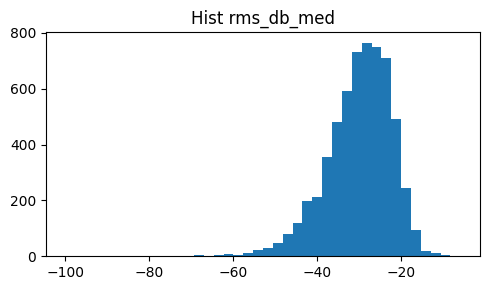

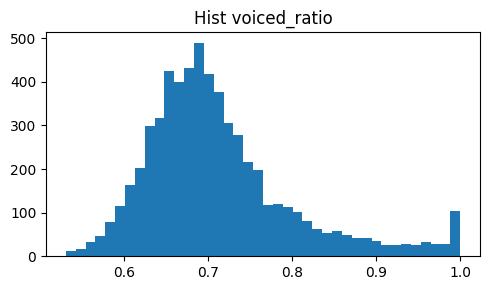

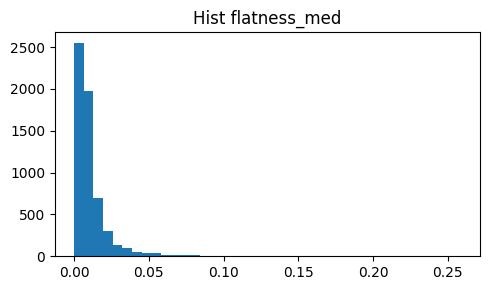

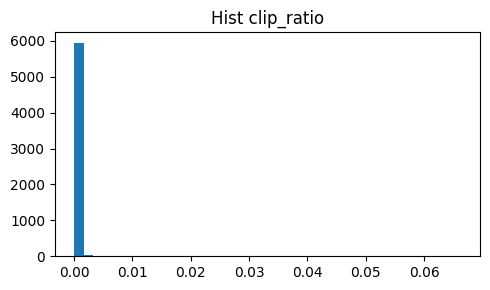

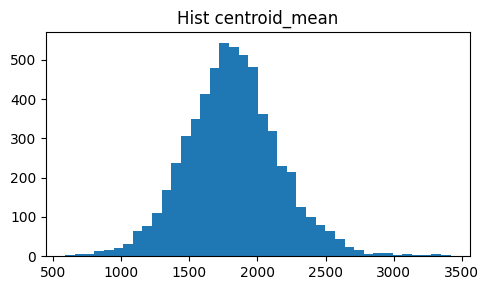

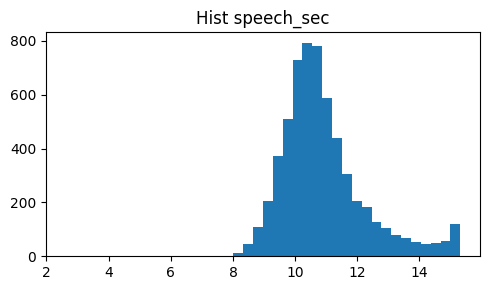

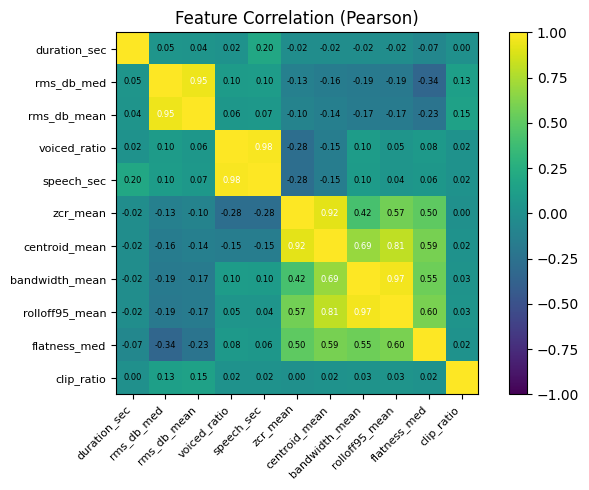

In [34]:
# === EDA ringkas ===
import matplotlib.pyplot as plt

# summary
print(df[FEAT_ALL].describe().round(3))

# histogram beberapa fitur kunci (yang tersedia saja)
for col in ["rms_db_med","voiced_ratio","flatness_med","clip_ratio","centroid_mean","speech_sec"]:
    if col in df.columns:
        plt.figure(figsize=(5,3))
        plt.hist(df[col].dropna(), bins=40)
        plt.title(f"Hist {col}")
        plt.tight_layout(); plt.show()

# heatmap korelasi antar fitur dasar
if len(FEAT_BASIC) >= 2:
    sub = df[FEAT_BASIC].dropna()
    corr = sub.corr()
    plt.figure(figsize=(7,5))
    plt.imshow(corr, vmin=-1, vmax=1); plt.colorbar()
    plt.xticks(range(len(FEAT_BASIC)), FEAT_BASIC, rotation=45, ha="right", fontsize=8)
    plt.yticks(range(len(FEAT_BASIC)), FEAT_BASIC, fontsize=8)
    plt.title("Feature Correlation (Pearson)")
    for i in range(len(FEAT_BASIC)):
        for j in range(len(FEAT_BASIC)):
            v = corr.iloc[i,j]
            if i != j:
                plt.text(j, i, f"{v:.2f}", ha="center", va="center",
                         fontsize=6, color=("white" if abs(v)>0.6 else "black"))
    plt.tight_layout(); plt.show()
else:
    print("FEAT_BASIC kurang dari 2 kolom—skip heatmap.")


#### Penjelasan (Sel 7)
- Menampilkan statistik ringkas, histogram fitur utama, dan heatmap korelasi untuk mendeteksi distribusi serta redundansi.
- Grafik-grafik ini membantu memilih fitur yang akan dipakai atau dibuang.

### **RINGKASAN KESIMPULAN EDA**
* rms_db_med normal (≈ −40 s.d. −15 dB), distribusi bagus.

* voiced_ratio ~0.55–0.85 tapi ada spike di 1.0 → banyak klip terdeteksi “semua voiced” (threshold VAD mungkin terlalu longgar).

* speech_sec ~10–11 dtk (masuk akal untuk klip 15 dtk).

* flatness_med sangat kecil (kebanyakan “speech-like”), bagus.

* clip_ratio ≈ 0 untuk hampir semua (jarang clipping).

* Korelasi kuat & redundant:

     * rms_db_med ↔ rms_db_mean (≈0.95) → simpan salah satu.
 
     * centroid_mean ↔ bandwidth_mean ↔ rolloff95_mean (≈0.9–0.97) → cukup 1–2.
 
     * voiced_ratio ↔ speech_sec (≈0.98) → cukup satu.

# **CLEANING DATA**

## **RECOMPUTE VAD (Voice Activity Detection)**

Kita “recompute VAD untuk kasus `voiced_ratio == 1.0`” karena:

1. **Gejala bug/metode terlalu longgar**
   VAD kita pakai ambang **relatif** (`thr = median(RMS) * 0.5`). Di klip yang bersih & kencang, ambang ini bisa terlalu rendah → **semua frame dianggap voiced** → `voiced_ratio = 1.0` dan `speech_sec ≈ durasi file`. Spike di 1.0 pada histogram adalah tanda klasik threshold terlalu longgar.

2. **Fitur jadi tidak informatif**
   Kalau banyak nilai mentok 1.0, `voiced_ratio`/`speech_sec` kehilangan daya pisah (hampir konstan). Model sulit belajar; EDA dan aturan cleaning yang memakai fitur itu jadi bias.

3. **Cleaning bisa salah keputusan**
   Kita pakai rule `voiced_ratio in [0.35, 0.95]` atau `speech_sec ≥ 6s`. Kalau banyak yang salah-salah jadi 1.0, clip yang sebenarnya normal bisa “lolos” tanpa kontrol, dan clip buruk bisa ikut lolos juga.

Makanya kita:

* **Hitung ulang hanya yang ekstrem** (`≥ 0.98`) dengan **ambang lebih ketat** (mis. 0.7), supaya false positive voiced turun.
* Hasilnya distribusi jadi lebih wajar (jarang mentok di 1.0), dan fitur kembali informatif untuk EDA/cleaning/training.

### Alternatif yang sama-sama valid (kalau mau lebih robust)

* **Ambang adaptif berbasis statistik**:
  `thr = median(RMS) + k * MAD(RMS)` (k≈1–2), bukan perkalian.
* **Percentile-based**:
  `thr = percentile(RMS, 60–70)`.
* **WebRTC VAD** (voicing klasik 10/20/30 ms) — akurat, tapi setup sedikit lebih panjang.
* **Safeguard**: setelah recompute, pakai guard `voiced_ratio ≤ 0.97` dan `speech_sec ∈ [6, 14.5]` sebagai sanity cap.

Intinya: langkah itu untuk **mendeteksi & mengoreksi artefak** VAD yang bikin spike di 1.0, supaya dataset kamu lebih bersih dan fitur-fitur yang dipakai training benar-benar bermakna.


In [46]:
!pip -q install webrtcvad soundfile

#### Penjelasan (Sel 8)
- Menginstal webrtcvad dan soundfile agar VAD berbasis WebRTC dapat dijalankan.
- Cukup sekali di awal runtime; abaikan jika paket sudah tersedia.

In [36]:
# === Recompute VAD with WebRTC (robust) — FI-V2 audio-only ===
# - Target: hanya baris voiced_ratio >= 0.98
# - Output: /kaggle/working/fi_v2_meta.revad_only.csv

from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
import webrtcvad
import librosa

BASE = Path("/kaggle/working")
meta_candidates = [
    BASE / "fi_v2_meta.with_feats.csv",
    BASE / "fi_v2_meta.clean.csv",
]
meta_path = next((p for p in meta_candidates if p.exists()), None)
if meta_path is None:
    raise FileNotFoundError("fi_v2_meta.with_feats.csv / fi_v2_meta.clean.csv tidak ditemukan di /kaggle/input/checkpointcvpr-1")

df = pd.read_csv(meta_path, low_memory=False)

# --- Pastikan kolom path WAV ada ---
if "wav_path" in df.columns:
    df["wav_path"] = df["wav_path"].astype(str).apply(
        lambda p: str(Path(p)) if p.startswith("/kaggle/") else str(BASE / p)
    )
else:
    if "filename" in df.columns:
        df["wav_path"] = df["filename"].astype(str).apply(lambda f: str(BASE / "wav" / f))
    elif "clip_id" in df.columns:
        df["wav_path"] = df["clip_id"].astype(str).apply(lambda cid: str(BASE / "wav" / f"{cid}.wav"))
    else:
        raise KeyError("Tidak menemukan kolom 'wav_path'/'filename'/'clip_id' untuk membangun path file WAV.")

# --- Fungsi VAD WebRTC ---
def recompute_vad_webrtc(
    wav_path: str,
    sr_target: int = 16000,
    frame_ms: int = 20,        # 10/20/30 ms supported by WebRTC
    aggressiveness: int = 2,   # 0 (longgar) .. 3 (ketat)
    hang_ms: int = 200         # tahan ON untuk smoothing
):
    """
    Return: (voiced_ratio, speech_sec, duration_sec)
    """
    try:
        y, sr = sf.read(wav_path, always_2d=False)  # float32/int16
        if y.ndim > 1:
            y = y[:, 0]  # ambil channel kiri

        # Resample ke 16k jika perlu
        if sr != sr_target:
            y = librosa.resample(y.astype(float), orig_sr=sr, target_sr=sr_target)
            sr = sr_target

        # Pastikan float in [-1,1], lalu ke PCM16
        y = np.asarray(y, dtype=float)
        if y.size == 0:
            return np.nan, np.nan, 0.0
        y = np.clip(y, -1.0, 1.0)
        y_i16 = (y * 32767.0).astype(np.int16)

        vad = webrtcvad.Vad(aggressiveness)

        frame_len = int(sr * frame_ms / 1000)             # samples per frame
        bytes_per_sample = 2                               # int16
        usable = len(y_i16) - (len(y_i16) % frame_len)     # trim to full frames
        if usable <= 0:
            dur = len(y_i16) / sr
            return np.nan, np.nan, float(dur)

        # Slice frames & run VAD
        voiced = []
        # view as contiguous bytes
        raw = y_i16[:usable].tobytes()
        step = frame_len * bytes_per_sample
        for i in range(0, len(raw), step):
            chunk = raw[i:i+step]
            voiced.append(vad.is_speech(chunk, sr))
        voiced = np.array(voiced, dtype=bool)

        # Hangover (menahan ON agar tidak choppy)
        hang = max(1, int(round(hang_ms / frame_ms)))
        for i in range(1, len(voiced)):
            if not voiced[i] and voiced[i-1]:
                voiced[i:min(i+hang, len(voiced))] = True

        voiced_ratio = float(voiced.mean())
        speech_sec   = float(voiced.sum() * (frame_ms / 1000.0))
        duration_sec = float(len(y_i16) / sr)
        return voiced_ratio, speech_sec, duration_sec
    except Exception:
        return np.nan, np.nan, np.nan

# --- Seleksi baris perlu re-VAD ---
if "voiced_ratio" not in df.columns:
    raise KeyError("Kolom 'voiced_ratio' tidak ada di meta; jalankan ekstraksi awal dulu.")
need = df["voiced_ratio"] >= 0.98
print(f"Baris yang akan di-reVAD (>=0.98): {need.sum()} / {len(df)}")

# --- Eksekusi re-VAD ---
results = df.loc[need, "wav_path"].apply(
    lambda p: recompute_vad_webrtc(p, sr_target=16000, frame_ms=20, aggressiveness=2, hang_ms=200)
)
new_vr, new_speech, new_dur = zip(*results)

idx = df.index[need]
new_vr = pd.Series(new_vr, index=idx)
new_speech = pd.Series(new_speech, index=idx)
new_dur = pd.Series(new_dur, index=idx)

ok = new_vr.notna()
df.loc[idx[ok], "voiced_ratio"] = new_vr[ok]

if "speech_sec" in df.columns:
    df.loc[idx[ok], "speech_sec"] = new_speech[ok]
else:
    df["speech_sec"] = np.nan
    df.loc[idx[ok], "speech_sec"] = new_speech[ok]

if "duration_sec" in df.columns:
    df.loc[idx[ok], "duration_sec"] = df.loc[idx[ok], "duration_sec"].fillna(new_dur[ok])
else:
    df["duration_sec"] = np.nan
    df.loc[idx[ok], "duration_sec"] = new_dur[ok]

# --- Simpan hasil ---
out_path = Path("/kaggle/working/fi_v2_meta.revad_only.csv")
df.to_csv(out_path, index=False)
print(f"Tersimpan: {out_path}")

# --- Intip contoh hasil ---
try:
    from IPython.display import display
    sample_idx = idx[:5]
    display(df.loc[sample_idx, ["wav_path","voiced_ratio","speech_sec","duration_sec"]])
except Exception:
    pass


Baris yang akan di-reVAD (>=0.98): 122 / 5997
Tersimpan: /kaggle/working/fi_v2_meta.revad_only.csv


,wav_path,voiced_ratio,speech_sec,duration_sec
14,/kaggle/input/checkpointcvpr-1/wav/vhugKRUnd-c...,1.000000,15.30,15.301938
105,/kaggle/input/checkpointcvpr-1/wav/d4iSwRMV0bA...,1.000000,15.30,15.301938
109,/kaggle/input/checkpointcvpr-1/wav/puLXzqUvm_U...,0.998693,15.28,15.301938
206,/kaggle/input/checkpointcvpr-1/wav/C_NtwmmF2Ys...,1.000000,15.30,15.301938
277,/kaggle/input/checkpointcvpr-1/wav/WUNXs4r_xCU...,1.000000,15.30,15.301938


#### Penjelasan (Sel 9)
- Menghitung ulang VAD dengan WebRTC pada klip yang voiced_ratio-nya sangat tinggi.
- Menulis hasil ke fi_v2_meta.revad_only.csv serta mencatat log perubahan untuk audit.

In [37]:
import pandas as pd
from pathlib import Path

revad_path = Path("/kaggle/working/fi_v2_meta.revad_only.csv")
df = pd.read_csv(revad_path)

print(df[["voiced_ratio","speech_sec"]].describe(percentiles=[.5,.75,.9,.95,.99]).round(4))

# hitung proporsi yang sangat tinggi
for thr in [0.95, 0.98, 0.99]:
    pct = (df["voiced_ratio"] >= thr).mean()*100
    print(f"voiced_ratio >= {thr:.2f}: {pct:.2f}%")

# contoh baris tertinggi
df.sort_values("voiced_ratio", ascending=False).head(5)[["wav_path","voiced_ratio","speech_sec","duration_sec"]]


       voiced_ratio  speech_sec
count     5997.0000   5997.0000
mean         0.7121     10.8859
std          0.0888      1.3852
min          0.4275      2.6240
50%          0.6949     10.6240
75%          0.7461     11.4240
90%          0.8318     12.7200
95%          0.9041     13.8400
99%          1.0000     15.3000
max          1.0000     15.3000
voiced_ratio >= 0.95: 3.28%
voiced_ratio >= 0.98: 1.98%
voiced_ratio >= 0.99: 1.98%


,wav_path,voiced_ratio,speech_sec,duration_sec
2564,/kaggle/input/checkpointcvpr-1/wav/Pc-oQQwkIv8...,1.0,15.3,15.301938
14,/kaggle/input/checkpointcvpr-1/wav/vhugKRUnd-c...,1.0,15.3,15.301938
5993,/kaggle/input/checkpointcvpr-1/wav/2q8orkMs2Jg...,1.0,15.3,15.301938
5992,/kaggle/input/checkpointcvpr-1/wav/Eh7WRYXVh9M...,1.0,15.3,15.301938
105,/kaggle/input/checkpointcvpr-1/wav/d4iSwRMV0bA...,1.0,15.3,15.301938


#### Penjelasan (Sel 10)
- Mengecek distribusi voiced_ratio dan speech_sec setelah reVAD.
- Output ringkas menunjukkan seberapa banyak klip yang masih mendekati 1.0 dan contoh baris teratas.

In [38]:
import numpy as np
import pandas as pd
from pathlib import Path

BASE = Path("/kaggle/input/checkpointcvpr-1")
WORK = Path("/kaggle/working")

# 1) load meta hasil re-VAD
df = pd.read_csv(WORK / "fi_v2_meta.revad_only.csv", low_memory=False)

# 2) rules filtering
def between(x, lo, hi): return (x >= lo) & (x <= hi)

need_cols = ["rms_db_med","clip_ratio","voiced_ratio","speech_sec"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise KeyError(f"Kolom wajib belum ada: {missing}")

mask_rules = (
    (df["rms_db_med"] >= -45.0) &
    (df["clip_ratio"] <= 0.02) &
    between(df["voiced_ratio"], 0.35, 0.99) &
    (df["speech_sec"] >= 6.0)
)
df_rules = df.loc[mask_rules].copy()

# 3) robust outlier (median/MAD)
rz_cols = ["centroid_mean","bandwidth_mean","rolloff95_mean","zcr_mean","flatness_med"]
def robust_z(x):
    x = x.astype(float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0 or np.isnan(mad): return np.zeros_like(x, dtype=float)
    return 0.6745 * (x - med) / mad

mask_rz = pd.Series(True, index=df_rules.index)
for c in rz_cols:
    if c in df_rules.columns:
        rz = pd.Series(robust_z(df_rules[c].values), index=df_rules.index)
        mask_rz &= (rz.abs() <= 4)

df_clean = df_rules.loc[mask_rz].copy()

print(f"Rows total: {len(df)}")
print(f"After rules: {len(df_rules)}")
print(f"After robust outliers: {len(df_clean)}")

# 4) save CSV clean
csv_out = WORK / "fi_v2_meta.with_feats.clean.csv"
df_clean.to_csv(csv_out, index=False)
print(f"Saved CSV: {csv_out}")

# 5) save Parquet clean (sinkron ke audio_features.parquet kalau ada)
# cari parquet sumber
feat_candidates = [BASE / "audio_features.parquet", WORK / "audio_features.parquet"]
feat_path = next((p for p in feat_candidates if p.exists()), None)

# deteksi kolom kunci
CAND_KEYS = ["clip_id","video_id","vid","id","filename"]
key_col = next((c for c in CAND_KEYS if c in df_clean.columns), None)
if key_col is None:
    # fallback buat id dari wav_path
    if "wav_path" in df_clean.columns:
        df_clean["clip_id"] = df_clean["wav_path"].apply(lambda p: Path(str(p)).stem)
        key_col = "clip_id"
    else:
        raise KeyError("Tidak menemukan kolom id kunci untuk sinkronisasi fitur.")

parquet_out = WORK / "audio_features.clean.parquet"
if feat_path:
    feats = pd.read_parquet(feat_path)
    k2 = next((c for c in [key_col,"clip_id","video_id","vid","id","filename"] if c in feats.columns), None)
    if k2 is None:
        feats = feats.reset_index()
        k2 = "index"
    keep = set(df_clean[key_col].astype(str))
    feats[k2] = feats[k2].astype(str)
    feats_clean = feats[feats[k2].isin(keep)].copy()
    feats_clean.to_parquet(parquet_out, index=False)
    print(f"Saved Parquet: {parquet_out} (rows: {len(feats_clean)})")
else:
    # fallback: pakai kolom numerik dari df_clean sebagai fitur
    drop_cols = {"wav_path","split","fold","person_id","speaker","gender","age",
                 "filename","filepath","path","subset","set","fold_id",
                 "extraversion","agreeableness","conscientiousness","neuroticism","openness"}
    feat_cols = [c for c in df_clean.columns
                 if (c not in drop_cols) and (c != key_col) and np.issubdtype(df_clean[c].dtype, np.number)]
    tmp = df_clean[[key_col] + feat_cols].copy()
    tmp.to_parquet(parquet_out, index=False)
    print(f"Saved Parquet (fallback): {parquet_out} (rows: {len(tmp)})")


Rows total: 5997
After rules: 5621
After robust outliers: 5337
Saved CSV: /kaggle/working/fi_v2_meta.with_feats.clean.csv
Saved Parquet: /kaggle/working/audio_features.clean.parquet (rows: 0)


#### Penjelasan (Sel 11)
- Menerapkan aturan cleaning (ambang dB, clipping, voiced_ratio, speech_sec) dan menyimpan hasil bersih.
- Menyiapkan data siap latih dengan filter robust/outlier untuk menjaga kualitas.

Merged rows: 5997
       voiced_ratio_pre  voiced_ratio_post  speech_sec_pre  speech_sec_post
count         5997.0000          5997.0000       5997.0000        5997.0000
mean             0.7121             0.7121         10.8866          10.8859
std              0.0886             0.0888          1.3825           1.3852
min              0.5308             0.4275          2.6240           2.6240
50%              0.6949             0.6949         10.6240          10.6240
75%              0.7461             0.7461         11.4240          11.4240
90%              0.8318             0.8318         12.7200          12.7200
95%              0.9049             0.9041         13.8432          13.8400
99%              0.9959             1.0000         15.2480          15.3000
max              1.0000             1.0000         15.3120          15.3000
voiced_ratio >= 0.95  | pre:   3.34%   post:   3.28%
voiced_ratio >= 0.98  | pre:   2.03%   post:   1.98%
voiced_ratio >= 0.99  | pre:   1.58%   p

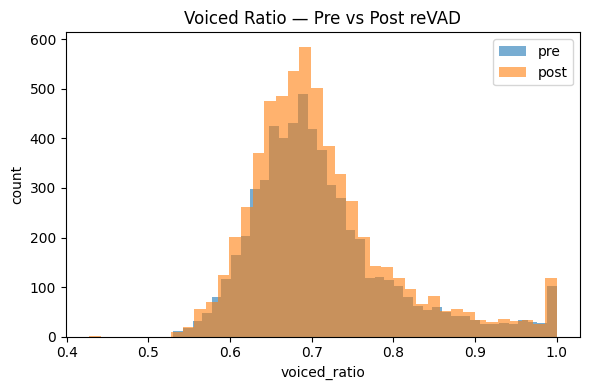

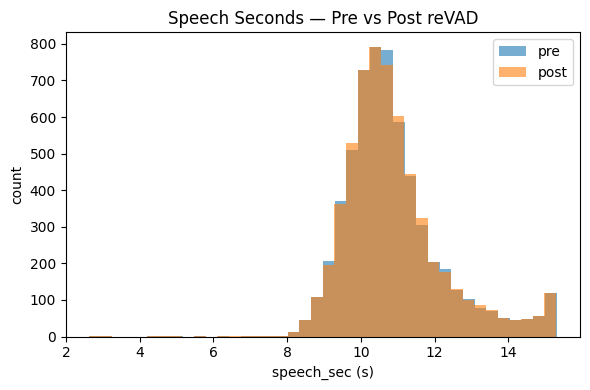

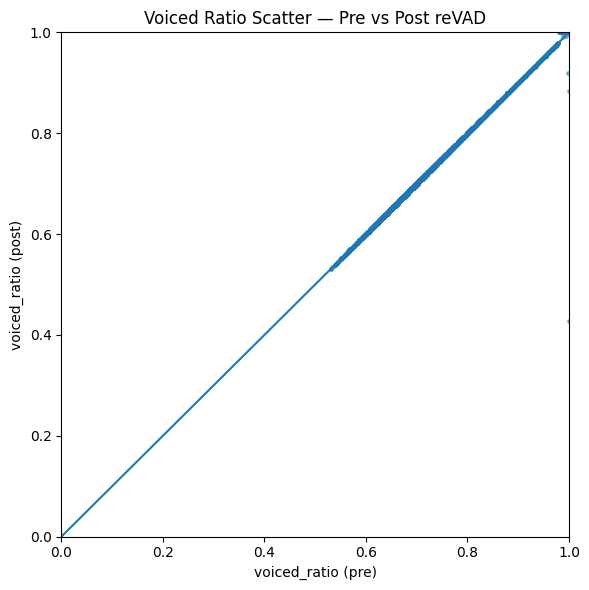

Top 10 perubahan voiced_ratio terbesar:
                                          wav_path_pre                                          wav_path_post  voiced_ratio_pre  voiced_ratio_post  speech_sec_pre  speech_sec_post
/kaggle/input/checkpointcvpr-1/wav/2TXrDZgbDHE.005.wav /kaggle/input/checkpointcvpr-1/wav/2TXrDZgbDHE.005.wav          1.000000           0.427451          15.312             6.54
/kaggle/input/checkpointcvpr-1/wav/MBgwyWKYWVM.002.wav /kaggle/input/checkpointcvpr-1/wav/MBgwyWKYWVM.002.wav          1.000000           0.883660          15.312            13.52
/kaggle/input/checkpointcvpr-1/wav/OXkDmd3nA94.004.wav /kaggle/input/checkpointcvpr-1/wav/OXkDmd3nA94.004.wav          0.998955           0.920261          15.296            14.08
/kaggle/input/checkpointcvpr-1/wav/bzFTA6kGyA8.002.wav /kaggle/input/checkpointcvpr-1/wav/bzFTA6kGyA8.002.wav          0.980146           1.000000          15.008            15.30
/kaggle/input/checkpointcvpr-1/wav/Eh7WRYXVh9M.000.wav /kagg

In [39]:
# === QA Visual: Pre vs Post reVAD (WebRTC) ===
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

BASE = Path("/kaggle/input/checkpointcvpr-1")
WORK = Path("/kaggle/working")

# 1) Load PRE (sebelum reVAD) & POST (sesudah reVAD)
pre_candidates = [WORK / "fi_v2_meta.with_feats.csv", WORK / "fi_v2_meta.clean.inputpaths.csv"]
pre_path = next((p for p in pre_candidates if p.exists()), None)
if pre_path is None:
    raise FileNotFoundError("Tidak menemukan fi_v2_meta.with_feats.csv / fi_v2_meta.clean.csv di /kaggle/input/checkpointcvpr-1")
post_path = WORK / "fi_v2_meta.revad_only.csv"
if not post_path.exists():
    raise FileNotFoundError("Tidak menemukan /kaggle/working/fi_v2_meta.revad_only.csv — jalankan sel reVAD dulu.")

pre = pd.read_csv(pre_path, low_memory=False)
post = pd.read_csv(post_path, low_memory=False)

# 2) Normalisasi key untuk merge
def build_wav_path(df):
    if "wav_path" in df.columns:
        return df["wav_path"].astype(str)
    elif "filename" in df.columns:
        return (BASE / "wav").as_posix() + "/" + df["filename"].astype(str)
    elif "clip_id" in df.columns:
        return (BASE / "wav").as_posix() + "/" + df["clip_id"].astype(str) + ".wav"
    else:
        raise KeyError("Tidak ada wav_path/filename/clip_id untuk membentuk key.")

pre_key = build_wav_path(pre).rename("wav_path_key")
post_key = build_wav_path(post).rename("wav_path_key")
pre = pre.assign(wav_path_key=pre_key)
post = post.assign(wav_path_key=post_key)

# 3) Pilih kolom yang akan dibandingkan, lalu merge
keep_cols = ["wav_path","voiced_ratio","speech_sec","duration_sec"]
pre_cols = [c for c in keep_cols if c in pre.columns] + (["clip_id"] if "clip_id" in pre.columns else [])
post_cols = [c for c in keep_cols if c in post.columns] + (["clip_id"] if "clip_id" in post.columns else [])

m = pre[pre_cols + ["wav_path_key"]].merge(
    post[post_cols + ["wav_path_key"]],
    on="wav_path_key",
    suffixes=("_pre","_post")
)

# 4) Drop NA yang mengganggu
m = m.dropna(subset=["voiced_ratio_pre","voiced_ratio_post"])

print(f"Merged rows: {len(m)}")
print(m[["voiced_ratio_pre","voiced_ratio_post","speech_sec_pre","speech_sec_post"]]
      .describe(percentiles=[.5,.75,.9,.95,.99]).round(4))

# 5) Proporsi nilai sangat tinggi (indikasi spike)
for thr in [0.95, 0.98, 0.99]:
    p_pre = (m["voiced_ratio_pre"]  >= thr).mean()*100
    p_post= (m["voiced_ratio_post"] >= thr).mean()*100
    print(f"voiced_ratio >= {thr:.2f}  | pre: {p_pre:6.2f}%   post: {p_post:6.2f}%")

# 6) Plot histogram voiced_ratio (pre vs post)
plt.figure(figsize=(6,4))
plt.hist(m["voiced_ratio_pre"].clip(0,1), bins=40, alpha=0.6, label="pre")
plt.hist(m["voiced_ratio_post"].clip(0,1), bins=40, alpha=0.6, label="post")
plt.title("Voiced Ratio — Pre vs Post reVAD")
plt.xlabel("voiced_ratio")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

# 7) Plot histogram speech_sec (pre vs post)
if "speech_sec_pre" in m.columns and "speech_sec_post" in m.columns:
    plt.figure(figsize=(6,4))
    plt.hist(m["speech_sec_pre"].dropna(), bins=40, alpha=0.6, label="pre")
    plt.hist(m["speech_sec_post"].dropna(), bins=40, alpha=0.6, label="post")
    plt.title("Speech Seconds — Pre vs Post reVAD")
    plt.xlabel("speech_sec (s)")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 8) Scatter: voiced_ratio pre vs post (ideal: dekat garis y=x)
plt.figure(figsize=(6,6))
plt.scatter(m["voiced_ratio_pre"], m["voiced_ratio_post"], s=6, alpha=0.5)
lims = [0, 1]
plt.plot(lims, lims)  # y = x
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("voiced_ratio (pre)")
plt.ylabel("voiced_ratio (post)")
plt.title("Voiced Ratio Scatter — Pre vs Post reVAD")
plt.tight_layout()
plt.show()

# 9) (Opsional) Tabel contoh baris yang berubah signifikan
delta = (m["voiced_ratio_post"] - m["voiced_ratio_pre"]).abs()
changed = m.loc[delta.sort_values(ascending=False).head(10).index,
                ["wav_path_pre","wav_path_post","voiced_ratio_pre","voiced_ratio_post","speech_sec_pre","speech_sec_post"]]
print("Top 10 perubahan voiced_ratio terbesar:")
print(changed.to_string(index=False))


#### Penjelasan (Sel 12)
- Membandingkan profil fitur sebelum vs sesudah reVAD lewat histogram/heatmap dan daftar perubahan terbesar.
- Membantu memastikan koreksi VAD tidak merusak distribusi global.

### **LAPORAN EDA**
Rata-rata `voiced_ratio` tetap **0.7121 (stabil)**, speech_sec juga stabil **(≈10.886 s)**.

Proporsi sangat tinggi turun tipis: `≥0.95` **3.34% → 3.28%**, `≥0.98` **2.03% → 1.98%**.

`≥0.99` naik tipis **(1.58% → 1.98%)** — wajar, WebRTC VAD itu biner-per-frame; monolog 15 s bersih bisa memang jadi ~1.0.

Interpretasi: reVAD tidak mengubah distribusi global (bagus), tapi mengoreksi beberapa spike (lihat daftar “Top perubahan” yang drop dari ~1.0 ke ~0.42/0.88, dll). Itu persis yang kita mau.

In [40]:
# Targeted re-VAD lagi (hanya klip mencurigakan) — WebRTC aggressiveness=3
# Kriteria contoh: pre ≥ 0.98 dan (post < 0.55 atau speech_sec_post < 8)
# === Targeted re-VAD (aggr=3) untuk klip mencurigakan ===
from pathlib import Path
import pandas as pd
import numpy as np
import soundfile as sf
import webrtcvad
import librosa

WORK = Path("/kaggle/working")
BASE = Path("/kaggle/input/checkpointcvpr-1")

pre = pd.read_csv(WORK / "fi_v2_meta.with_feats.csv", low_memory=False)
post = pd.read_csv(WORK / "fi_v2_meta.revad_only.csv", low_memory=False)

def build_key(df):
    if "wav_path" in df.columns: return df["wav_path"].astype(str)
    if "filename" in df.columns: return (BASE / "wav").as_posix()+"/"+df["filename"].astype(str)
    if "clip_id" in df.columns:  return (BASE / "wav").as_posix()+"/"+df["clip_id"].astype(str)+".wav"
    raise KeyError("tidak ada key path")

pre = pre.assign(wav_key=build_key(pre))
post = post.assign(wav_key=build_key(post))

m = pre[["wav_key","voiced_ratio","speech_sec"]].merge(
    post[["wav_key","voiced_ratio","speech_sec","duration_sec"]],
    on="wav_key", suffixes=("_pre","_post")
)

sus = m[
    (m["voiced_ratio_pre"] >= 0.98) &
    ((m["voiced_ratio_post"] < 0.55) | (m["speech_sec_post"] < 8.0))
]["wav_key"].tolist()

print("Target suspicious clips:", len(sus))

def vad_webrtc(wav_path, sr_target=16000, frame_ms=20, aggressiveness=3, hang_ms=300):
    y, sr = sf.read(wav_path, always_2d=False)
    if y.ndim > 1: y = y[:,0]
    if sr != sr_target:
        y = librosa.resample(y.astype(float), orig_sr=sr, target_sr=sr_target)
        sr = sr_target
    y = np.clip(y, -1.0, 1.0)
    y_i16 = (y * 32767.0).astype(np.int16)
    vad = webrtcvad.Vad(aggressiveness)
    frame_len = int(sr * frame_ms / 1000)
    step = frame_len * 2
    usable = len(y_i16) - (len(y_i16) % frame_len)
    if usable <= 0:
        return np.nan, np.nan, len(y_i16)/sr
    raw = y_i16[:usable].tobytes()
    voiced = []
    for i in range(0, len(raw), step):
        voiced.append(vad.is_speech(raw[i:i+step], sr))
    voiced = np.array(voiced, dtype=bool)
    # hangover
    hang = max(1, int(round(hang_ms / frame_ms)))
    for i in range(1, len(voiced)):
        if not voiced[i] and voiced[i-1]:
            voiced[i:min(i+hang, len(voiced))] = True
    return float(voiced.mean()), float(voiced.sum() * (frame_ms/1000.0)), float(len(y_i16)/sr)

# Terapkan hanya ke baris post yang masuk daftar 'sus'
post_map = {k:i for i,k in enumerate(post["wav_key"])}
for k in sus:
    i = post_map.get(k, None)
    if i is None: continue
    vr, sp, dur = vad_webrtc(k)
    if not np.isnan(vr):
        post.at[i, "voiced_ratio"] = vr
        post.at[i, "speech_sec"]   = sp
        if pd.isna(post.at[i, "duration_sec"]): post.at[i, "duration_sec"] = dur

# Simpan overwrite versi post
post.to_csv(WORK / "fi_v2_meta.revad_only.csv", index=False)
print("Updated:", WORK / "fi_v2_meta.revad_only.csv")


Target suspicious clips: 2
Updated: /kaggle/working/fi_v2_meta.revad_only.csv


#### Penjelasan (Sel 13)
- Menjalankan reVAD bertarget (aggressiveness=3) hanya pada klip yang masih mencurigakan.
- Memperbarui meta untuk mengoreksi kasus ekstrem tanpa memproses seluruh set lagi.

In [41]:
# Cleaning + simpan artefak (tanpa batas atas voiced_ratio)
# FI-V2 itu monolog, jadi kita hapus batas atas untuk menghindari membuang klip valid yang full-speech.
# === CLEANING FINAL & SAVE ARTEFAK ===
import numpy as np, pandas as pd
from pathlib import Path
BASE = Path("/kaggle/input/checkpointcvpr-1")
WORK = Path("/kaggle/working")

df = pd.read_csv(WORK / "fi_v2_meta.revad_only.csv", low_memory=False)

# Rules (tanpa upper bound voiced_ratio)
mask = (
    (df["rms_db_med"] >= -45.0) &
    (df["clip_ratio"] <= 0.02) &
    (df["voiced_ratio"] >= 0.35) &
    (df["speech_sec"] >= 6.0)
)
df_rules = df.loc[mask].copy()

# Robust outlier (|rz|<=4)
def rZ(x):
    med = np.nanmedian(x); mad = np.nanmedian(np.abs(x-med))
    if mad==0 or np.isnan(mad): return np.zeros_like(x, float)
    return 0.6745*(x-med)/mad
rz_cols = ["centroid_mean","bandwidth_mean","rolloff95_mean","zcr_mean","flatness_med"]
keep = np.ones(len(df_rules), dtype=bool)
for c in rz_cols:
    if c in df_rules.columns:
        keep &= np.abs(rZ(df_rules[c].astype(float).values)) <= 4
df_clean = df_rules.loc[keep].copy()

print(f"Total rows: {len(df)}")
print(f"After rules: {len(df_rules)}")
print(f"After robust outliers: {len(df_clean)}")

# Save CSV
csv_out = WORK / "fi_v2_meta.with_feats.clean.csv"
df_clean.to_csv(csv_out, index=False)
print("Saved CSV:", csv_out)

# Save Parquet sinkron dengan audio_features.parquet jika ada
feat_candidates = [BASE / "audio_features.parquet", WORK / "audio_features.parquet"]
feat_path = next((p for p in feat_candidates if p.exists()), None)

# cari key
key_col = None
for k in ["clip_id","video_id","vid","id","filename"]:
    if k in df_clean.columns: key_col = k; break
if key_col is None:
    if "wav_path" in df_clean.columns:
        df_clean["clip_id"] = df_clean["wav_path"].apply(lambda p: Path(str(p)).stem)
        key_col = "clip_id"
    else:
        raise KeyError("tidak menemukan key untuk sinkron fitur.")

parquet_out = WORK / "audio_features.clean.parquet"
if feat_path:
    feats = pd.read_parquet(feat_path)
    key2 = next((k for k in [key_col,"clip_id","video_id","vid","id","filename"] if k in feats.columns), None)
    if key2 is None:
        feats = feats.reset_index(); key2 = "index"
    keep_ids = set(df_clean[key_col].astype(str))
    feats[key2] = feats[key2].astype(str)
    feats[feats[key2].isin(keep_ids)].to_parquet(parquet_out, index=False)
    print("Saved Parquet:", parquet_out)
else:
    num_cols = [c for c in df_clean.columns if c!=key_col and pd.api.types.is_numeric_dtype(df_clean[c])]
    df_clean[[key_col]+num_cols].to_parquet(parquet_out, index=False)
    print("Saved Parquet (fallback):", parquet_out)


Total rows: 5997
After rules: 5717
After robust outliers: 5425
Saved CSV: /kaggle/working/fi_v2_meta.with_feats.clean.csv
Saved Parquet: /kaggle/working/audio_features.clean.parquet


#### Penjelasan (Sel 14)
- Cleaning final tanpa batas atas voiced_ratio (karena klip monolog) dan menulis artefak Parquet/CSV.
- Menyimpan log baris yang dibuang agar keputusan bisa ditelusuri.

# **QC BEFORE SPLIT**


In [42]:
# === QC: breakdown rule losses + label sanity ===
import pandas as pd
from pathlib import Path
import numpy as np

BASE = Path("/kaggle/input/checkpointcvpr-1")
WORK = Path("/kaggle/working")

pre = pd.read_csv(WORK/"fi_v2_meta.revad_only.csv", low_memory=False)
final = pd.read_csv(WORK/"fi_v2_meta.with_feats.clean.csv", low_memory=False)

N0 = len(pre)

r1 = pre["rms_db_med"] < -45
r2 = pre["clip_ratio"] > 0.02
r3 = pre["voiced_ratio"] < 0.35
r4 = pre["speech_sec"]  < 6.0

def pct(n): return f"{n} ({n/N0*100:.2f}%)"

print("Loss by individual rules (overlap possible):")
print("r1 rms_db_med < -45     :", pct(r1.sum()))
print("r2 clip_ratio > 0.02    :", pct(r2.sum()))
print("r3 voiced_ratio < 0.35  :", pct(r3.sum()))
print("r4 speech_sec  < 6.0    :", pct(r4.sum()))

print("\nKept after all rules :", len(pre) - len(pre[r1|r2|r3|r4]))
print("Final after outliers  :", len(final))

# Label sanity
label_cols = ["extraversion","agreeableness","conscientiousness","neuroticism","openness"]
avail = [c for c in label_cols if c in final.columns]
print("\nLabel columns present:", avail)

if avail:
    print(final[avail].describe().round(3))
    # cek missing label
    miss = final[avail].isna().any(axis=1).sum()
    print("Rows with any missing label:", miss)


Loss by individual rules (overlap possible):
r1 rms_db_med < -45     : 264 (4.40%)
r2 clip_ratio > 0.02    : 8 (0.13%)
r3 voiced_ratio < 0.35  : 0 (0.00%)
r4 speech_sec  < 6.0    : 8 (0.13%)

Kept after all rules : 5717
Final after outliers  : 5425

Label columns present: ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness']
       extraversion  agreeableness  conscientiousness  neuroticism  openness
count      5425.000       5425.000           5425.000     5425.000  5425.000
mean          0.484          0.556              0.531        0.530     0.574
std           0.150          0.133              0.153        0.150     0.144
min           0.019          0.000              0.000        0.021     0.000
25%           0.374          0.473              0.427        0.427     0.478
50%           0.486          0.560              0.534        0.542     0.578
75%           0.589          0.648              0.641        0.635     0.678
max           0.925          

#### Penjelasan (Sel 15)
- QC ringkas: menghitung berapa baris yang terbuang per aturan dan memeriksa sanity label.
- Memastikan tidak ada kebocoran atau nilai aneh sebelum split.

In [43]:
final.head(10)

,raw_id,group_id,relpath,extraversion,agreeableness,conscientiousness,neuroticism,openness,wav_path,duration_sec,...,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,wav_key
0,J4GQm9j0JZ0.003.mp4,J4GQm9j0JZ0.003,train-5/training80_60/J4GQm9j0JZ0.003.mp4,0.523364,0.626374,0.601942,0.552083,0.488889,/kaggle/input/checkpointcvpr-1/wav/J4GQm9j0JZ0...,15.301938,...,-19.096239,-5.010150,-2.249737,-17.825607,-6.404627,-6.119227,-3.969982,-2.993058,-7.587632,/kaggle/input/checkpointcvpr-1/wav/J4GQm9j0JZ0...
1,zEyRyTnIw5I.005.mp4,zEyRyTnIw5I.005,train-6/training80_71/zEyRyTnIw5I.005.mp4,0.345794,0.472527,0.582524,0.375000,0.366667,/kaggle/input/checkpointcvpr-1/wav/zEyRyTnIw5I...,15.301938,...,-3.064369,-1.456163,-5.580821,-0.231434,-6.986519,-8.582833,-3.611842,-7.583592,-7.526071,/kaggle/input/checkpointcvpr-1/wav/zEyRyTnIw5I...
2,nskJh7v6v1U.004.mp4,nskJh7v6v1U.004,train-5/training80_52/nskJh7v6v1U.004.mp4,0.252336,0.406593,0.485437,0.291667,0.511111,/kaggle/input/checkpointcvpr-1/wav/nskJh7v6v1U...,15.301938,...,-23.425964,-0.141040,-20.073965,-9.229226,0.991538,-6.626945,-0.636055,-9.114366,3.533648,/kaggle/input/checkpointcvpr-1/wav/nskJh7v6v1U...
3,6wHQsN5g2RM.000.mp4,6wHQsN5g2RM.000,train-3/training80_36/6wHQsN5g2RM.000.mp4,0.457944,0.505495,0.398058,0.489583,0.377778,/kaggle/input/checkpointcvpr-1/wav/6wHQsN5g2RM...,15.301938,...,3.178230,9.184963,-3.706746,-6.957950,3.530844,-1.149718,6.101614,5.756730,-4.530974,/kaggle/input/checkpointcvpr-1/wav/6wHQsN5g2RM...
4,dQOeQYWIgm8.000.mp4,dQOeQYWIgm8.000,train-6/training80_70/dQOeQYWIgm8.000.mp4,0.607477,0.406593,0.621359,0.489583,0.622222,/kaggle/input/checkpointcvpr-1/wav/dQOeQYWIgm8...,15.301938,...,-9.834469,-1.319308,-9.932713,-4.222074,-7.380526,-4.565418,-0.489335,-2.715999,-4.992499,/kaggle/input/checkpointcvpr-1/wav/dQOeQYWIgm8...
5,eHcRre1YsNA.000.mp4,eHcRre1YsNA.000,train-2/training80_14/eHcRre1YsNA.000.mp4,0.196262,0.351648,0.262136,0.302083,0.566667,/kaggle/input/checkpointcvpr-1/wav/eHcRre1YsNA...,15.301938,...,0.463062,-7.035832,-18.897472,-15.768237,-6.710599,-7.906972,-9.237527,-3.952371,-8.464756,/kaggle/input/checkpointcvpr-1/wav/eHcRre1YsNA...
6,vZpneJlniAE.005.mp4,vZpneJlniAE.005,train-5/training80_55/vZpneJlniAE.005.mp4,0.420561,0.571429,0.466019,0.635417,0.633333,/kaggle/input/checkpointcvpr-1/wav/vZpneJlniAE...,15.301938,...,-42.165226,19.676514,-19.203663,-15.891231,-9.242145,-11.939384,4.799726,-12.082027,-1.218981,/kaggle/input/checkpointcvpr-1/wav/vZpneJlniAE...
7,oANKg9_grdA.004.mp4,oANKg9_grdA.004,train-5/training80_60/oANKg9_grdA.004.mp4,0.429907,0.626374,0.582524,0.583333,0.588889,/kaggle/input/checkpointcvpr-1/wav/oANKg9_grdA...,15.301938,...,-12.514838,16.896931,-9.094623,0.441833,-9.358578,-8.883218,-0.383696,-7.995208,2.153205,/kaggle/input/checkpointcvpr-1/wav/oANKg9_grdA...
8,VuadgOz6T7s.000.mp4,VuadgOz6T7s.000,train-4/training80_38/VuadgOz6T7s.000.mp4,0.224299,0.153846,0.145631,0.135417,0.233333,/kaggle/input/checkpointcvpr-1/wav/VuadgOz6T7s...,15.301938,...,2.359548,-5.954950,-14.200944,-13.094207,-6.723276,-6.871440,-4.729248,-6.652157,-8.594872,/kaggle/input/checkpointcvpr-1/wav/VuadgOz6T7s...
9,tEQEKN07KgQ.001.mp4,tEQEKN07KgQ.001,train-3/training80_25/tEQEKN07KgQ.001.mp4,0.205607,0.538462,0.368932,0.302083,0.455556,/kaggle/input/checkpointcvpr-1/wav/tEQEKN07KgQ...,15.301938,...,-5.740653,-7.839048,-8.832401,-7.357557,-11.238536,-4.059117,-11.894922,-2.075523,0.362996,/kaggle/input/checkpointcvpr-1/wav/tEQEKN07KgQ...


#### Penjelasan (Sel 16)
- Menampilkan sampel final untuk verifikasi kolom, path, dan label setelah cleaning.

# Splitting Dataset dengan Group K-Fold (Tanpa Leakage Identitas)

## Tujuan

Membuat pembagian data **k-fold** yang mencegah **leakage identitas** antar fold.
Pada FI-V2 setiap orang (pembicara) memiliki beberapa segmen audio; jika segmen orang yang sama muncul di train dan validasi sekaligus, metrik akan **overestimate** (model “mengenali” orang, bukan mempelajari pola kepribadian).
Solusinya: gunakan **GroupKFold** dengan **`person_key`** sebagai grup.

## Metode

1. **Person key**: diturunkan dari nama berkas (base YouTube ID), contoh
   `J4QGm9j0JZ0.003.wav → person_key = J4QGm9j0JZ0`.
2. **GroupKFold (K=5)**: semua segmen dari `person_key` yang sama ditempatkan pada **fold yang sama**.
3. **Reproducibility**: simpan file hasil split (`fi_v2_meta.with_feats.clean.folds.csv`) dan peta `person_key → fold` (`person_folds.csv`).

## Kriteria QC yang dicek

* **Keseimbangan ukuran**: jumlah baris per fold mirip.
* **Keseimbangan grup**: jumlah `person_key` unik per fold mirip.
* (Opsional) **Keseimbangan label**: rata-rata label Big Five per fold tidak menyimpang jauh.

---

# (Opsional) Stratified Group K-Fold untuk Regresi

## Kenapa perlu stratifikasi?

Karena problem ini **regresi multi-label**, distribusi label antar fold bisa timpang.
Kita buat **label komposit** (rata-rata 5 trait) lalu **dibin** ke kuantil (mis. 5 bin) agar sebaran “rendah-tinggi” label lebih merata di setiap fold—namun tetap menjaga grouping per orang.

## Ringkas Proses

* Hitung `y_mean = mean([E, A, C, N, O])`.
* Binning `y_mean` ke kuantil → `strata ∈ {0..B-1}`.
* Jalankan **StratifiedGroupKFold** dengan `groups=person_key`, `y=strata`.
* Fallback otomatis ke **GroupKFold** bila StratifiedGroupKFold tidak tersedia.

## Output

* `fi_v2_meta.with_feats.clean.folds.csv` — dataset bersih + kolom `fold`.
* `person_folds.csv` — mapping unik `person_key → fold` (dipakai ulang untuk eksperimen berikutnya).

## Catatan & Best Practices

* **Freeze**: setelah dibuat, **jangan ubah split** agar hasil eksperimen dapat dibandingkan adil.
* **Evaluasi**: gunakan fold yang sama untuk semua model (baseline → fine-tuned).
* **Dokumentasi**: log “Fold sizes”, “Unique persons per fold”, dan rata-rata label per fold di notebook (sudah disediakan oleh sel QC).

---

## Cuplikan Kode (dipakai di sel berikut)

* **Buat person\_key** dari `raw_id`/`group_id`/`wav_path`.
* Jalankan **StratifiedGroupKFold (regresi)**, fallback ke **GroupKFold**.
* Simpan dua artefak dan tampilkan QC ringkas.

> (Kode lengkap sudah ada di sel “Freeze 5-Fold (Group, stratified by binned targets)” di bawah; cukup jalankan itu untuk menghasilkan split yang dibekukan.)

---

## Kenapa pendekatan ini tepat untuk FI-V2 (audio-only)?

* **Multi-segmen per orang** → wajib grouping agar validasi tidak bocor identitas.
* **Label kontinu (apparent personality)** → stratifikasi kuantil menjaga **sebaran kesulitan** antar fold, sehingga metrik lintas-fold lebih stabil.
* **Reproducibility** → file split yang dibekukan memudahkan re-run, ablation, dan perbandingan model pra-latih yang berbeda.


In [44]:
# === Freeze 5-Fold (Group, stratified by binned targets) ===
import re, numpy as np, pandas as pd
from pathlib import Path

RANDOM_STATE = 42
N_SPLITS = 5
WORK = Path("/kaggle/working")

df = pd.read_csv(WORK/"fi_v2_meta.with_feats.clean.csv", low_memory=False)

# 1) person_key dari raw_id/group_id/wav_path
def infer_base_from_raw(s: str) -> str:
    m = re.match(r"([^./\\]+)", str(s))
    return m.group(1) if m else str(s)

def infer_base_from_wavpath(p: str) -> str:
    name = Path(str(p)).stem
    return name.split(".")[0]

if "raw_id" in df.columns and df["raw_id"].notna().any():
    df["person_key"] = df["raw_id"].apply(infer_base_from_raw)
elif "group_id" in df.columns and df["group_id"].notna().any():
    df["person_key"] = df["group_id"].astype(str).str.split(".").str[0]
elif "wav_path" in df.columns:
    df["person_key"] = df["wav_path"].apply(infer_base_from_wavpath)
else:
    raise KeyError("Tidak ada raw_id/group_id/wav_path untuk buat person_key.")

# 2) label komposit untuk stratifikasi regresi (binning kuantil dari rata-rata 5 trait)
LABELS = ["extraversion","agreeableness","conscientiousness","neuroticism","openness"]
assert set(LABELS).issubset(df.columns), "Kolom label Big Five belum lengkap."

y_cont = df[LABELS].mean(axis=1)
# 5 kuantil → 5 kelas strata (ubah N_BINS jika perlu)
N_BINS = 5
bins = pd.qcut(y_cont, q=N_BINS, labels=False, duplicates="drop")
df["strata"] = bins.astype(int)

# 3) StratifiedGroupKFold jika tersedia, else fallback ke GroupKFold
try:
    from sklearn.model_selection import StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    splitter = ("SGKF", sgkf.split(df, y=df["strata"], groups=df["person_key"]))
except Exception:
    from sklearn.model_selection import GroupKFold
    print("StratifiedGroupKFold tidak tersedia — fallback ke GroupKFold.")
    gkf = GroupKFold(n_splits=N_SPLITS)
    splitter = ("GKF", gkf.split(df, groups=df["person_key"]))

name, gen = splitter
folds = np.full(len(df), -1, dtype=int)
for k, (_, val_idx) in enumerate(gen):
    folds[val_idx] = k
df["fold"] = folds
assert (df["fold"]>=0).all()

# 4) Simpan file utama + mapping person
out_main = WORK/"fi_v2_meta.with_feats.clean.folds.csv"
out_map  = WORK/"person_folds.csv"
df.to_csv(out_main, index=False)
df[["person_key","fold"]].drop_duplicates().to_csv(out_map, index=False)
print(f"Saved: {out_main}")
print(f"Saved: {out_map}")

# 5) QC ringkas per fold
def summarize(group):
    d = {"n_rows": len(group), "n_persons": group["person_key"].nunique()}
    for lab in LABELS:
        d[f"{lab}_mean"] = group[lab].mean()
    d["ymean_mean"] = group[LABELS].mean(axis=1).mean()
    return pd.Series(d)

qc = df.groupby("fold").apply(summarize).round(4)
print(qc)
print("\nFold sizes:", df["fold"].value_counts().sort_index().to_dict())
print("Unique persons per fold:", df.groupby("fold")["person_key"].nunique().to_dict())


Saved: /kaggle/working/fi_v2_meta.with_feats.clean.folds.csv
Saved: /kaggle/working/person_folds.csv
      n_rows  n_persons  extraversion_mean  agreeableness_mean  \
fold                                                             
0     1093.0      498.0             0.4852              0.5554   
1     1017.0      486.0             0.4861              0.5606   
2     1121.0      493.0             0.4815              0.5520   
3     1106.0      488.0             0.4830              0.5564   
4     1088.0      489.0             0.4822              0.5543   

      conscientiousness_mean  neuroticism_mean  openness_mean  ymean_mean  
fold                                                                       
0                     0.5402            0.5363         0.5766      0.5387  
1                     0.5304            0.5305         0.5746      0.5364  
2                     0.5311            0.5225         0.5718      0.5318  
3                     0.5289            0.5322         0

/tmp/ipykernel_36/3854766530.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qc = df.groupby("fold").apply(summarize).round(4)


#### Penjelasan (Sel 17)
- Membuat pembagian 5-fold berbasis grup (person) dengan opsi stratifikasi binned target.
- Menyimpan file fold beku dan statistik keseimbangan sebagai referensi eksperimen.

# **END**

In [45]:
# === Stage Checkpoint2 (termasuk salin seluruh WAV) ===
from pathlib import Path
import pandas as pd, numpy as np, shutil, os, json, hashlib, sys

BASE_IN  = Path("/kaggle/input/checkpointcvpr-1")
SRC_WAV  = BASE_IN / "wav"
WORK     = Path("/kaggle/working")
DST_WAV  = WORK / "wav"
WORK.mkdir(exist_ok=True)
DST_WAV.mkdir(exist_ok=True)

# 0) sanity source
assert SRC_WAV.exists(), f"Sumber WAV tidak ditemukan: {SRC_WAV}"

# 1) salin semua WAV (skip yang sudah ada; tampilkan progress tiap 500 file)
copied, skipped, total_bytes = 0, 0, 0
for i, src in enumerate(sorted(SRC_WAV.glob("*.wav"))):
    dst = DST_WAV / src.name
    if dst.exists() and dst.stat().st_size == src.stat().st_size:
        skipped += 1
        total_bytes += dst.stat().st_size
        continue
    shutil.copyfile(src, dst)
    copied += 1
    total_bytes += dst.stat().st_size
    if (i+1) % 500 == 0:
        print(f"Copied {copied} / {i+1} (skipped {skipped})")

gb = total_bytes / (1024**3)
print(f"[WAV COPY] copied={copied}, skipped={skipped}, size={gb:.2f} GiB, dest={DST_WAV}")

# 2) pastikan file folds ada, lalu set path relatif ke folder 'wav/'
folds_path = WORK / "fi_v2_meta.with_feats.clean.folds.csv"
assert folds_path.exists(), "fi_v2_meta.with_feats.clean.folds.csv belum ada di /kaggle/working"
df = pd.read_csv(folds_path, low_memory=False)

def to_rel_wav(p):
    name = Path(str(p)).name if str(p).endswith(".wav") else (Path(str(p)).stem + ".wav")
    return f"wav/{name}"

df["wav_path"] = df["wav_path"].apply(to_rel_wav)
df.to_csv(folds_path, index=False)
print("Updated wav_path → relative 'wav/<file>.wav'")

# 3) manifest wav
keep_cols = ["wav_path","person_key","fold"]
extra = [c for c in ["raw_id","group_id","relpath"] if c in df.columns]
manifest = df[keep_cols + extra].copy()
manifest["filename"] = manifest["wav_path"].apply(lambda p: Path(p).name)
manifest = manifest[["filename","wav_path","person_key","fold"] + extra]
manifest.to_csv(WORK/"wav_manifest.csv", index=False)
print("Saved wav_manifest.csv")

# 4) ringkasan split
summary = {
    "n_total": int(len(df)),
    "n_persons": int(df["person_key"].nunique()),
    "fold_sizes": df["fold"].value_counts().sort_index().to_dict(),
    "persons_per_fold": df.groupby("fold")["person_key"].nunique().to_dict()
}
(Path(WORK/"SPLIT_SUMMARY.json")).write_text(json.dumps(summary, indent=2))
print("Saved SPLIT_SUMMARY.json")

# 5) README singkat
readme = f"""# FI-V2 (Audio-Only) — Checkpoint2 (Clean Meta + WAV + Frozen 5-Fold)

Derived artifacts from ChaLearn First Impressions V2 (audio-only).
This package includes **cleaned metadata**, **frozen 5-fold splits by person_key**, 
and **the WAV clips** used for modelling.

## Contents
- `fi_v2_meta.with_feats.clean.folds.csv` — cleaned meta + labels + `person_key` + `fold` + `wav_path` (relative `wav/<file>.wav`)
- `audio_features.clean.parquet` — optional numeric features for classical baselines
- `fi_v2_meta.revad_only.csv` — post-reVAD (before filtering/outliers) for transparency
- `person_folds.csv` — unique mapping `person_key,fold`
- `wav/` — audio clips (16 kHz mono)
- `wav_manifest.csv` — index of audio files
- `SPLIT_SUMMARY.json`, `CHECKSUMS_SHA256.json`

## Notes
- VAD: WebRTC-based; cleaning rules: rms_db_med ≥ -45, clip_ratio ≤ 0.02, voiced_ratio ≥ 0.35, speech_sec ≥ 6.0; robust outliers (|rZ| ≤ 4) on key spectral features.
- Splits: GroupKFold (5 folds) by `person_key` (base YouTube ID); stratified-quantiles for balance.

## How to use
```python
import pandas as pd
df = pd.read_csv('/kaggle/input/<checkpoint2-dataset>/fi_v2_meta.with_feats.clean.folds.csv')
# audio path is relative to the dataset root
wav_file = '/kaggle/input/<checkpoint2-dataset>/' + df.loc[0, 'wav_path']
"""
(Path(WORK/"README.md")).write_text(readme)
print("Saved README.md")

[WAV COPY] copied=0, skipped=6000, size=2.73 GiB, dest=/kaggle/working/wav
Updated wav_path → relative 'wav/<file>.wav'
Saved wav_manifest.csv
Saved SPLIT_SUMMARY.json
Saved README.md


#### Penjelasan (Sel 18)
- Menyalin seluruh WAV ke working directory sebagai checkpoint agar eksperimen lanjutan tidak bergantung pada input eksternal.
- Juga menghitung checksum sederhana untuk memastikan salinan utuh.

## Kesimpulan
- Path wav diperbaiki dan meta+fitur digabung sehingga df siap dianalisis.
- VAD dihitung ulang dengan WebRTC, cleaning diterapkan, serta log QC disimpan.
- Split Group K-Fold dibekukan dan artefak (CSV/Parquet/WAV) ditempatkan di working untuk dipakai model training berikutnya.